<font size="10">  
    Desafío mejorar modelo
</font> 

El objetivo de este desafío es obtener una mejor predicción del item *ventas* respecto al *modelo actual*. 

El plan de trabajo en este *jupyter notebook* se divide en tres secciones:

1. Realizar un análisis exploratorio de datos. Es fundamental tener una comprensión de la base de datos que uno está trabajando. Analizaremos de manera global las ventas, y  considerando el tamaño de la base de datos, analizaremos cuatro productos distintos y estudiaremos su comportamiento respecto al tiempo para verificar la existencia o inexistencia de patrones.

2. Crearemos y evaluaremos el rendimiento de distintos modelos. Explicaremos porque elegimos cada modelo, y las validaciones que aplicaremos para evaluar su rendimiento. El objetivo es lograr obtener mejores predicciones que el modelo actual.

3. Conclusiones y posibles planes a futuro.

#    1. Análisis exploratorio de datos. 

En esta sección nos enforcaremos en analizar los datos entregados. Revisaremos el rango de fechas entregada, la posible existencia de valores nulos, si existen relaciones entre los distintos productos y crearemos nuevos *feature* que consideremos importantes. 

Empezamos importando los paquetes necesarios. 

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import backtesting_forecaster

from xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

Cargamos el archivo csv entregado para analizarlo. El dataframe contiene la siguiente información:
- **fecha**: Fecha, dada como el primer día de cada mes, de la información de cada producto. El rango de fechas es de 2012-01 a 2023-12, pero no todos los *prod_id* tienen valores en todo el rango.
- **Prod_id** : Un id de cada producto agrícola. Existen 1000 productos distintos.
- **precio_promedio**: Precio promedio del producto en un mes dado.
- **ventas**: Ventas del producto en un mes dado.
- **modelo_actual**: La proyección de demanda que el modelo actual predijo para ese mes.

Queremos lograr predecir el valor *ventas* mejorando el valor obtenido por el modelo actual. Por lo tanto, el desafío es un problema de *time series forecasting*.

Leemos el archivo .csv, ordenamos la columna *fecha* y la usamos como indice, con un periodo mensual.

In [7]:
df = pd.read_csv("input/df.csv")
df = df.sort_values(by='fecha')
df["fecha"] = pd.to_datetime(df["fecha"])
df.set_index("fecha", inplace=True)
print("La base de datos tiene dimensiones", df.shape)

La base de datos tiene dimensiones (80748, 4)


Revisamos los primeros 5 elementos para obtener una idea de los datos con los cuáles trabajaremos.

In [8]:
df.head()

,prod_id,precio_promedio,ventas,modelo_actual
fecha,,,,
2012-01-01,698,8280.073778,436.0,441.953878
2012-01-01,167,1961.219324,1880.0,1960.518724
2012-01-01,331,4843.074738,819.0,860.015182
2012-01-01,931,12346.697520,1408.0,1351.436692
2012-01-01,530,6194.495105,1540.0,1522.800893


Revisamos el tipo de cada columna, el periodo, y si existen valores nulos

In [9]:
print("Información de cada columna:", "\n")
df.info()

Información de cada columna: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80748 entries, 2012-01-01 to 2023-12-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prod_id          80748 non-null  int64  
 1   precio_promedio  80748 non-null  float64
 2   ventas           80748 non-null  float64
 3   modelo_actual    80748 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.1 MB


Calculamos su matriz de correlación:

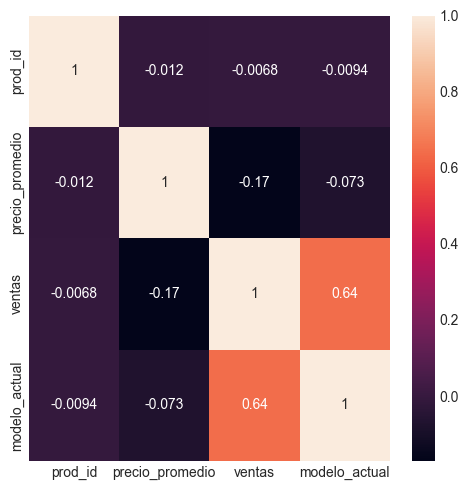

In [10]:
fig, ax = plt.subplots(figsize= (5,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

Al ver de manera general, existe una correlación de las ventas con el modelo_actual, lo cual era esperable pues el modelo actual está intentando modelarlo. 

Analicemos el comportamiento mensual de los datos:

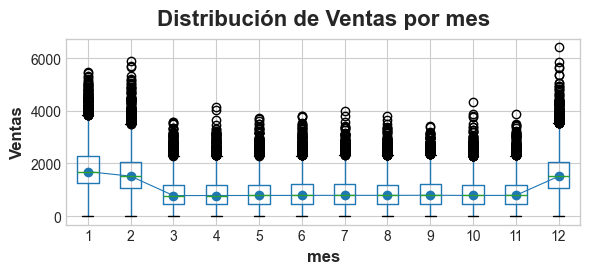

In [11]:
fig, ax = plt.subplots(figsize=(6, 3))
df["mes"] = df.index.month
df.boxplot(column="ventas", by="mes", ax=ax,)
df.groupby("mes")["ventas"].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel("Ventas")
ax.set_title("Distribución de Ventas por mes")
fig.suptitle('')
plt.show();
df = df.drop(["mes"], axis = 1)

Podemos notar que, de manera general entre los productos, existe una estacionalidad anual con un mayor número de ventas en los meses de diciembre, enero y febrero (verano).

Estudiemos ahora la autocorrelación (correlacción con sus datos *lagged*) y autocorrelación parcial (autocorrelación ajustada al tiempo).

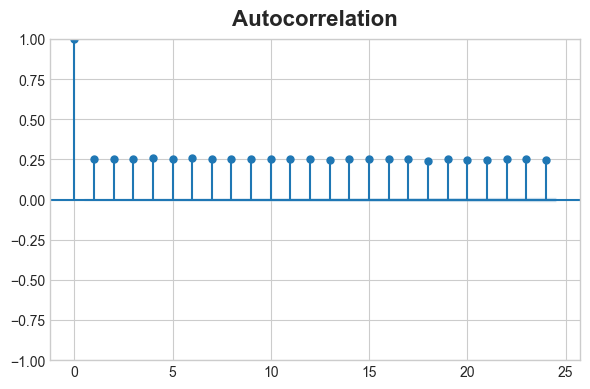

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_acf(df["ventas"], ax=ax, lags=24)
plt.show()

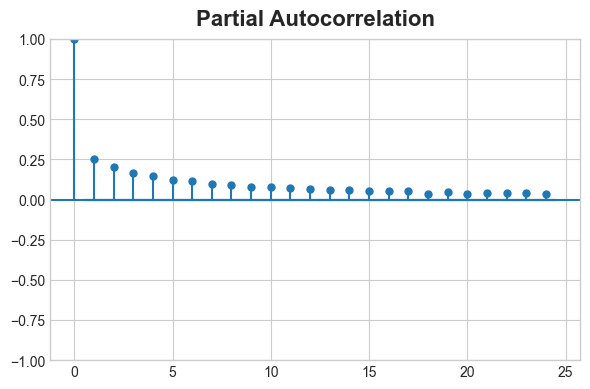

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_pacf(df["ventas"], ax=ax, lags=24)
plt.show()

Considerando que cada *id* representa un producto distinto, haremos un *groupby* respecto al id para tener una estimación del rango de fechas.

In [14]:
print("Promedio, media, desviación estándar y quartiles de las cantidad de fechas:\n", df.groupby("prod_id").count().describe())

Promedio, media, desviación estándar y quartiles de las cantidad de fechas:
        precio_promedio       ventas  modelo_actual
count      1000.000000  1000.000000    1000.000000
mean         80.748000    80.748000      80.748000
std          34.704537    34.704537      34.704537
min          12.000000    12.000000      12.000000
25%          60.000000    60.000000      60.000000
50%          84.000000    84.000000      84.000000
75%         108.000000   108.000000     108.000000
max         144.000000   144.000000     144.000000


Podemos notar que el rango de meses para cada producto varía de 12 meses (1 año) a 144 meses (12 años), con un promedio de 80 meses, y el mayor rango es desde 2012-01 a 2023-12. La primera pregunta que nos planteamos es: 

**Considerando que cada producto es independiente, ¿Existen diferencia en el comportamiento de las ventas, y por ende del modelo actual, durante el tiempo entre cada prod_id?.**

Para responder esto analizaremos distintos prod_id que tengan un periodo de fechas de rango maximal. Creamos una función para graficar rápidamente el comportamiento a través del tiempo de cada prod_id.

In [15]:
def prod_id_plot(df, prod_id): #Función para graficar ventas respecto al tiempo, y media movil de 4 meses de ventas/modelo actual, dado un prod_id.
    fig, (ax1,ax2) = plt.subplots(2, figsize = (8,5))
    fig.subplots_adjust(hspace = 0.3)
    df[df["prod_id"] == prod_id]["ventas"].plot(ax = ax1, color='0.3', label = "Ventas")
    df[df["prod_id"] == prod_id]["modelo_actual"].plot(ax = ax1, color='green', label = "Modelo Actual")
    ax1.legend()
    ax1.set_xlabel("Fechas")
    ax1.set_ylabel("Ventas")
    ax1.set_title("Grafico de Ventas respecto al tiempo del producto " + str(prod_id));
    df[df["prod_id"] == prod_id][["ventas", "modelo_actual"]].rolling(
    window=4,       
    center=True,      
    min_periods=2,  
    ).mean().plot(
    ax=ax2, linewidth=1.5, title="Ventas y Modelo actual - media móvil de 4-meses", legend=True,
    );

Nos interesa estudiar las *ventas* del producto respecto al tiempo. Por lo que graficaremos ventas respecto al tiempo para visualizar si existe algún tipo de patrón. Además, añadiremos la media móvil de las ventas y del modelo actual, para ver su comportamiento.

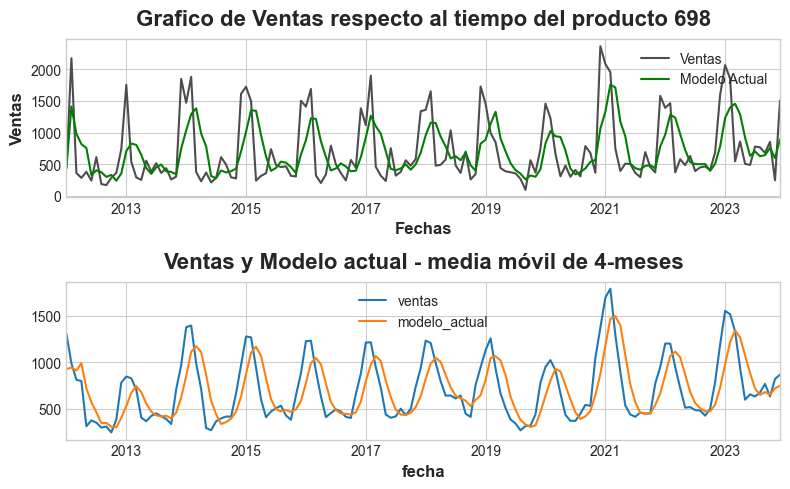

In [16]:
prod_id_plot(df, 698)

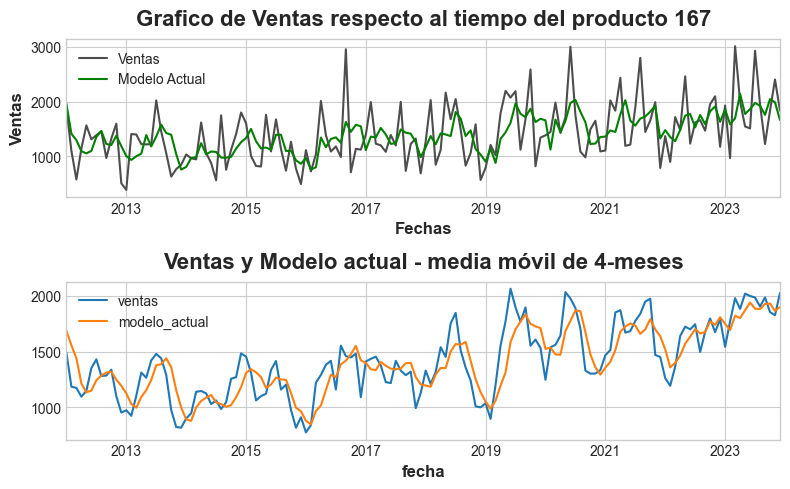

In [17]:
prod_id_plot(df, 167)

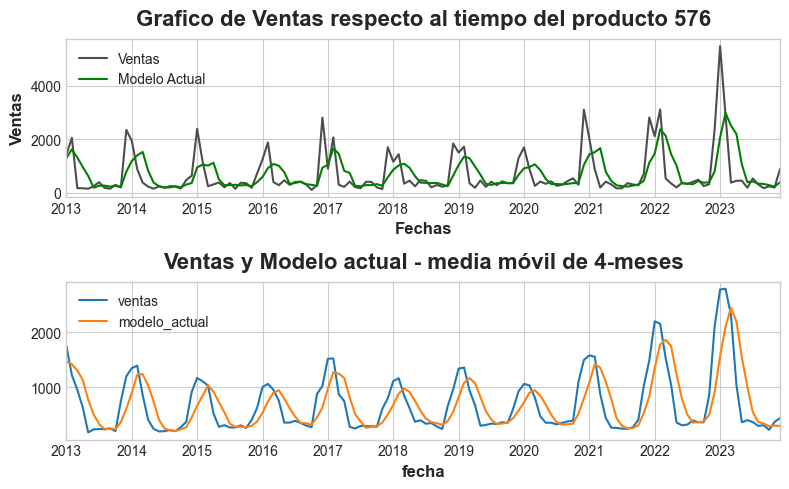

In [18]:
prod_id_plot(df, 576)

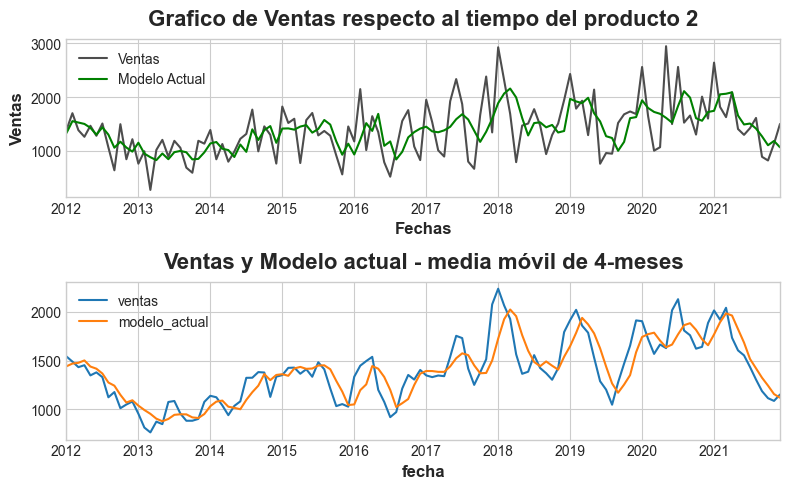

In [19]:
prod_id_plot(df, 2)

Podemos obtener nuestras primeras conclusiones: 
- El producto 698 y 576 tiene un comportamiento de variación estacional (*seasonality*) anual, con un peak de ventas durante el verano. Este comportamiento no se observa en el producto 2 y producto 167.
- Durante el periodo 2015-2019, las ventas del producto 698 y 576 tuvieron un fuerte comportamiento regular. En este caso la predición *naive forecasting*, de predecir el mismo valor que el año pasado, hubiera obtenido resultados excelentes. En los últimos años ambos productos han tenido un cambio en su comportamiento.
- Predecir los productos 2 y 167 es más complejo al tener un comportamiento irregular.
- El modelo actual tiene un comportamiento regular con valores acotados, que no logra predecir los valores máximos y mínimos de las ventas.
- El modelo actual, visto a través de su media movil de 4 meses, parecería tener un buen rendimiento en cuanto a predicciones. 
- El modelo actual parecería no tiene la capacidad de reacción suficiente respecto a los cambios del comportamiento de ventas.

Conjeturamos lo siguiente:

**El modelo actual tiene un buen rendimiento visto a través de su media movil de 4-meses, pero no tiene la capacidad de reacción ni la variabilidad suficiente.**

Para analizar de mejora manera la dependencia de las ventas respecto a sus valores antiguos, analizaremos su gráfico *lagged*. 

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 1.5, nrows * 1.5 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig
#Funciones obtenidas de https://www.kaggle.com/code/ryanholbrook/time-series-as-features

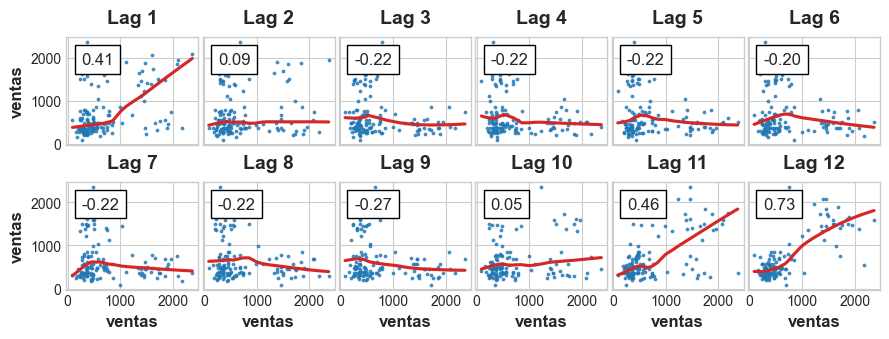

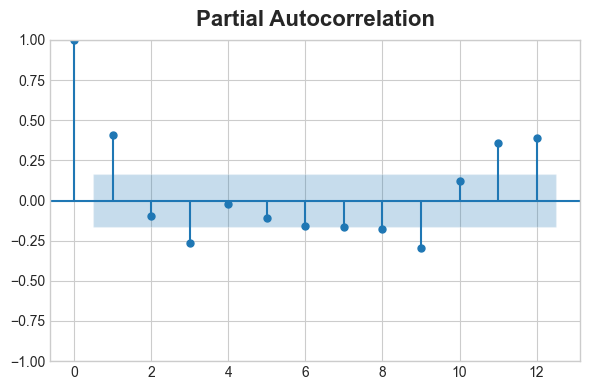

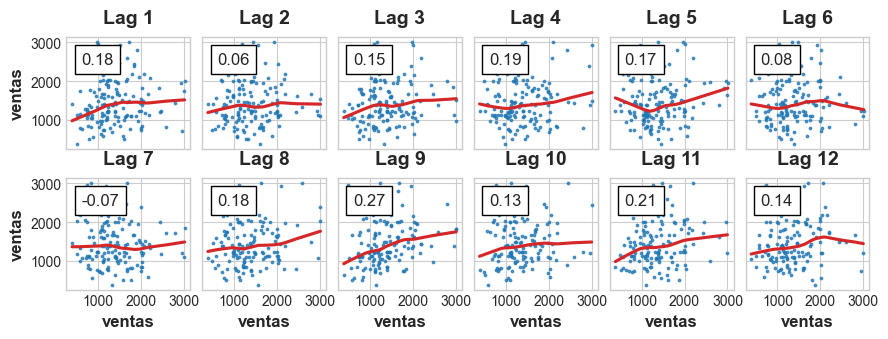

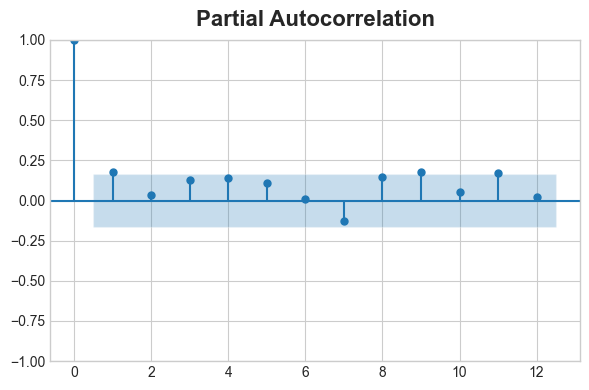

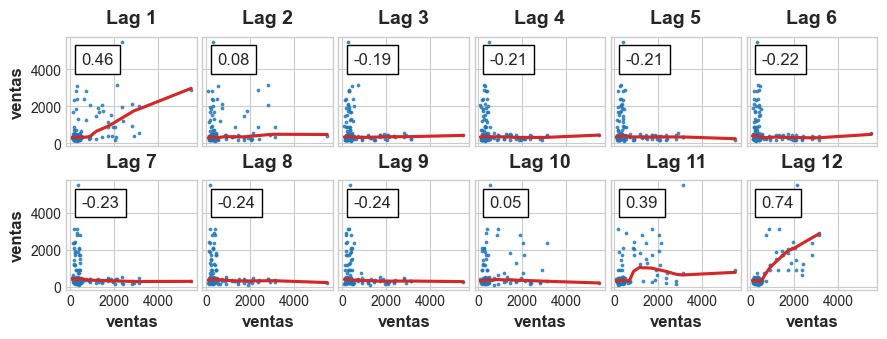

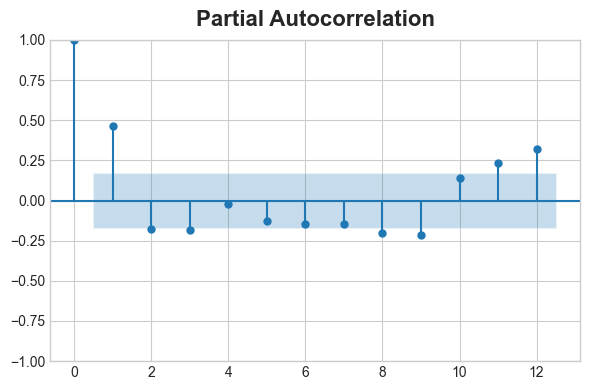

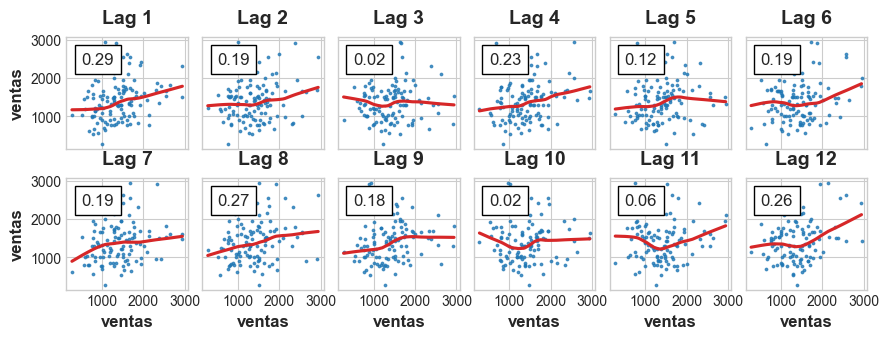

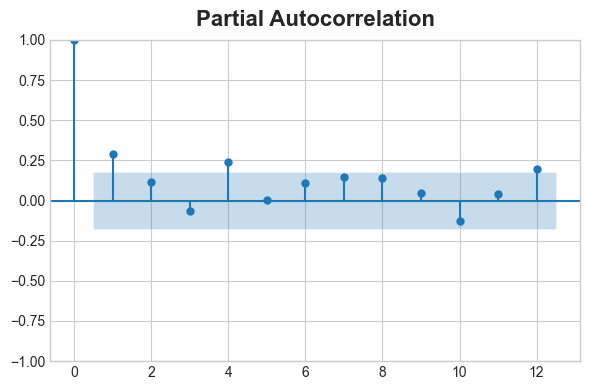

In [21]:
_ = plot_lags(df[df["prod_id"] == 698]["ventas"], lags=12, nrows=2)
fig = plot_pacf(df[df["prod_id"] == 698]["ventas"], lags=12)
fig.set_figheight(4)
fig.set_figwidth(6)
_ = plot_lags(df[df["prod_id"] == 167]["ventas"], lags=12, nrows=2)
fig = plot_pacf(df[df["prod_id"] == 167]["ventas"], lags=12)
fig.set_figheight(4)
fig.set_figwidth(6)
_ = plot_lags(df[df["prod_id"] == 576]["ventas"], lags=12, nrows=2)
fig = plot_pacf(df[df["prod_id"] == 576]["ventas"], lags=12)
fig.set_figheight(4)
fig.set_figwidth(6)
_ = plot_lags(df[df["prod_id"] == 2]["ventas"], lags=12, nrows=2)
fig = plot_pacf(df[df["prod_id"] == 2]["ventas"], lags=12)
fig.set_figheight(4)
fig.set_figwidth(6)

Podemos concluir lo siguiente: No existe una relación lineal **clara** entre los datos y su *lag* de manera uniforme entre los productos. El lag 11 y 12 presentan cierto indicio de relación lineal, lo cual puede moderlarse por la periodicidad anual de los datos. Aún así, algunos productos si presentan una relación con su *lag*, y por ende, incluiremos esta información al momento de crear modelos para intentar obtener un mejor rendimiento.


Para considerar los efectos que cada mes puede tener en el total de ventas crearemos columnas con esta información. Para mantener la dimensión del menor tamaño posible, sólo crearemos 11 columnas, siendo *diciembre* representado por la 11-tupla $(0, 0, \dots, 0, 0)$.

In [40]:
Meses = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre"]
exog = Meses + ["modelo_actual"]
for i in range(11):
    df[Meses[i]] = (df.index.month == i+1).astype(float)
df.head()

,prod_id,precio_promedio,ventas,modelo_actual,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre
fecha,,,,,,,,,,,,,,,
2012-01-01,698,8280.073778,436.0,441.953878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01,167,1961.219324,1880.0,1960.518724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01,331,4843.074738,819.0,860.015182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01,931,12346.697520,1408.0,1351.436692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01,530,6194.495105,1540.0,1522.800893,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Creación y evaluación de modelos predictivos

Ahora, aplicaremos algunos modelos para ver el rendimiento que podemos obtener. Como la información del modelo actual está disponible, consideraremos sus predicciones para realizar la nueva predicción (Un *stacking* de modelos). Los posibles modelos que nos interesa evaluar son:

1. Regresión lineal: Un modelo rigido y con gran interpretabilidad. Con lo variado de los datos, probablemente no obtenga el mejor rendimiento, pero su interpretabilidad permite obtener información sobre nuestra base de datos.

2. Random Forest Regressor: Un módelo menos rigido, pero aún interpretable. Las separaciones que realiza el algoritmo pueden ser valiosas para entender más los datos.

3. XGBoost: Un modelo aún interpretable, pero con un gran rendimiento.

4. Modelos híbridos: Mezclar modelos y usar el output de un modelo en otro puede mejorar el rendimiento de las predicciones.

El último punto es fundamental, pues ciertos módelos no logran modelar el crecimiento continuo (*trend*) de los datos respecto al tiempo, y por ende, puede no lograr modelar de manera correcta respecto al tiempo.

Podemos intentar dos metodos para hacer estas predicciones:

- Crear un modelo para cada *prod_id*. Esto lo podemos hacer a través de un *pipeline* que luego podemos aplicar a través de un loop.

- Crear un modelo en la base de datos global, y luego restringirnos a cada *prod_id*.

Asumiremos que existe independencia entre las ventas a través del tiempo de cada producto, por lo cual usaremos el primer metodo. Como son 1000 productos, un Hot One Encoding incrementaría demasiado la dimensión de nuestros datos, por lo cual crearemos cada modelo a través de un loop.

Empezamos separando nuestra data en train y test set. Separamos nuestra data en dos rangos, donde el test serán los últimos 3 meses del rango de fechas dado para cada prod_id Para validar nuestro modelo usaremos una norma $L^1$ (valor absoluto de las diferencias). 

Respecto al tiempo de predicción consideramos que un rango de 1 a 3 meses es un tiempo suficiente de forecasting. Entre más acotado sea el rango de predicción, es más factible realizar predicciones acertadas. Como el modelo actual predice solo el mes siguiente, nosotros nos enfocaremos en la misma tarea, pero programando el modelo para que sea simple predecir más meses.

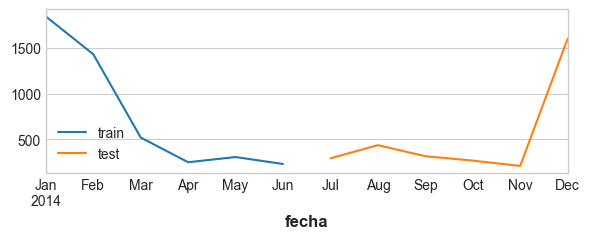

In [23]:
indice = {}
indice_mas_uno = {}
meses_a_predecir = 6
for i in range(0,1000):
    indice[i] = df[df["prod_id"] == i].index[df[df["prod_id"] == i].index.month == 12 - meses_a_predecir][-1] #Forma rapida de obtener la fecha de corte del test set.
    indice_mas_uno[i] = df[df["prod_id"] == i].index[df[df["prod_id"] == i].index.month == 12 - meses_a_predecir + 1][-1] #Mismo que arriba.
fig, ax = plt.subplots(figsize=(6, 2.5))
df[df["prod_id"] == 5][:indice[5]]["ventas"].plot(ax=ax, label='train')
df[df["prod_id"] == 5][indice_mas_uno[5]:]["ventas"].plot(ax=ax, label='test')
ax.legend();

La data la separaremos por *prod_id*. Cada uno de estos nuevas base de datos se organizaran en un diccionario indexado por el *prod_id*.

In [24]:
forecast = {}
data_train_col = {}
data_test_col = {}
data_modelo_actual = {}
for i in range(0,1000): #data_train_col y data_test_col son diccionarios en que la data de prod_id está indexada por i.
    data_train_col[i] = df[df["prod_id"] == i][:indice[i]]
    data_train_col[i] = data_train_col[i].asfreq('MS')
    data_test_col[i] = df[df["prod_id"] == i][indice_mas_uno[i]:]
    data_test_col[i] = data_test_col[i].asfreq('MS')
    data_modelo_actual[i] = df[df["prod_id"] == i][indice_mas_uno[i]:]["modelo_actual"]

In [25]:
dp = {}
model = {}
X = {}
X_train = {}
X_test = {}
y_fit = {}
y_pred = {}
trend_train = {}
trend_test = {}
for i in range(0,1000): #Para cada i, creamos el trend de la time series de ese prod_id = i.
    dp[i] = DeterministicProcess(
    index=df[df["prod_id"] == i].index,  
    constant=True,  
    order=1,       
    drop=True,     
)
    X[i] = dp[i].in_sample()
    X_train[i], X_test[i] = X[i][:indice[i]], X[i][indice_mas_uno[i]:]
    model[i] = LinearRegression(fit_intercept=False)
    model[i].fit(X_train[i], data_train_col[i]["ventas"])

    trend_train[i] = pd.DataFrame(
    model[i].predict(X_train[i]),
    index=data_train_col[i].index,
    columns=["ventas"],
)
    data_train_col[i]["Trend"] = trend_train[i]
    
    trend_test[i] = pd.DataFrame(
    model[i].predict(X_test[i]),
    index=data_test_col[i].index,
    columns=["ventas"],
)
    data_test_col[i]["Trend"] = trend_test[i]

Para los primeros modelos usaremos la libreria **skforecast**, basada en *scikit-learn*, que falicita la creación de *forecasting*. Entre sus utilidades está:

- Permite distintos tipos de forecasting (Recursive multi-step forecasting, Direct multi-step forecasting, Multiple output forecasting, etc.).
- Crea fácilmente *lagged* información como *feature*.
- Admite variables externas (*exog*).
- Admite modelo de regresión importados de *scikit-learn*.
- Permite hacer *backtesting*.
- Permite hacer *hyperparamenter tuning*.
- Crea intervalos de confianza con la precisión dada para los valores predecidos.

Construiremos un modelo de Recursive multi-step forecasting, donde el *regressor* será una regresión lineal, un random forest regressor y un XGRegressor. Entre las *features* elegiremos lags dependiendo de la cantidad de datos, y usaremos como *features exog* los meses, precio_promedio y el modelo_actual.

La creación de las predicciones sigue el siguiente procedimiento:

Para cada $i \in \{ 0,\dots, 999\}$ crearemos un modelo de la forma descrita anteriormente. Validaremos simultaneamente todos los modelos usando backtesting y calcularemos el promedio de sus *metric*. Para calcular el error de predicción, calcularemos la suma de todos las diferencias en *norma 2* de la predicciones con los target value, y la compararemos a la suma de las diferencias en *norma 2* del modelo actual con el target value.

Empezamos con el modelo con regresión lineal. Como una regresión lineal es computacionalmente simple, calcularemos también para cada predicción un intervalo de 99% de confianza.

In [41]:
forecast = {} #Diccionario en que guardaremos un modelo para cada i
metric = {} #Valor obtenido del backtesting.
for i in range(0,1000):
    if len(df[df["prod_id"] == i][:indice[i]].index) < 7: #Dependiendo el largo de la serie elegimos cuantos lagged features usamos.
        forecast[i] = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags      = 3
             )
    elif len(df[df["prod_id"] == i][:indice[i]].index) < 12: #Dependiendo el largo de la serie elegimos cuantos lagged features usamos.
        forecast[i] = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags      = 6
             )
    else: #Dependiendo el largo de la serie elegimos cuantos lagged features usamos.
        forecast[i] = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags      = 11
             )
    steps = 6 #Como queremos predecir 6 meses, el backtesting es la misma cantidad.
    n_backtesting = int(len(data_train_col[i])/3) 
    metric[i], _ = backtesting_forecaster(
                                   forecaster         = forecast[i],
                                   y                  = data_train_col[i]["ventas"],
                                   initial_train_size = len(data_train_col[i]) - n_backtesting,
                                   exog = data_train_col[i][exog],
                                   fixed_train_size   = False,
                                   steps              = steps,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   verbose            = False,
                                   show_progress      = False
                               ) #Backtesting
    forecast[i].fit(y=data_train_col[i]["ventas"], exog=data_train_col[i][exog]) #Hacemos fit a cada modelo
print(f"Backtest training error: {np.array(list(metric.values())).mean()/1000}")
steps = meses_a_predecir
predictions = {}
for i in range(0,1000):
    predictions[i] = forecast[i].predict_interval(steps=steps, 
                                                  interval = [1, 99], n_boot   = 500, 
                                                  exog = data_test_col[i][exog]) #Predicciones de cada modelo
sum_nueva_pred = 0
sum_antigua_pred = 0
for i in range(0,1000):
    sum_nueva_pred += (np.square(np.sqrt(data_test_col[i]["ventas"] - predictions[i]["pred"]))).sum()
    sum_antigua_pred += (np.square(np.sqrt(data_test_col[i]["ventas"] - data_modelo_actual[i]))).sum()
print("Error de predicción nueva (Linear Regression con Lagged info y exog variables) (2-norm):", sum_nueva_pred)
print("Error de predicción actual (2-norm):", sum_antigua_pred)
print("Porcentaje de mejora respecto al modelo actual:", ((sum_antigua_pred-sum_nueva_pred)/sum_antigua_pred)*100,"%")

Backtest training error: 2618291050.21393
Error de predicción nueva (Linear Regression con Lagged info y exog variables) (2-norm): 1046668.5070341561
Error de predicción actual (2-norm): 1282352.7902541782
Porcentaje de mejora respecto al modelo actual: 18.37905177196258 %


Podemos visualizar los resultados de nuestra predicción en dos productos (producto 2 y producto 698) junto a los respectivos intervalos de confianza:

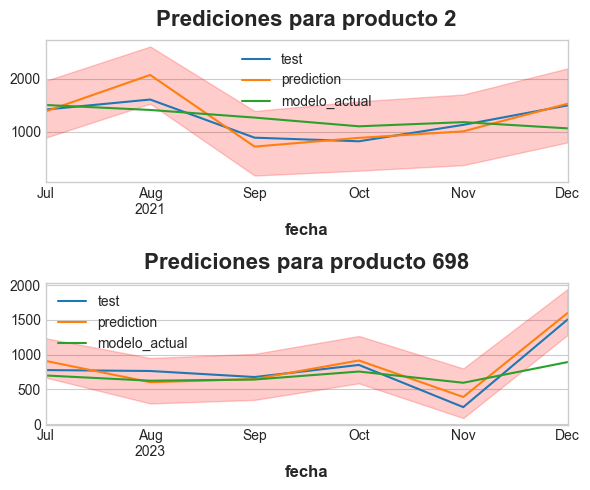

In [27]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(6, 5))
data_test_col[2]["ventas"].plot(ax=ax1, label='test')
predictions[2]["pred"].plot(ax=ax1, label='prediction')
data_modelo_actual[2].plot(ax=ax1, label='modelo_actual')
ax1.fill_between(
    predictions[2].index,
    predictions[2]['lower_bound'],
    predictions[2]['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax1.legend();
ax1.set_title("Prediciones para producto 2")
data_test_col[698]["ventas"].plot(ax=ax2, label='test')
predictions[698]["pred"].plot(ax=ax2, label='prediction')
data_modelo_actual[698].plot(ax=ax2, label='modelo_actual')
ax2.fill_between(
    predictions[698].index,
    predictions[698]['lower_bound'],
    predictions[698]['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax2.legend()
ax2.set_title("Prediciones para producto 698");

Seguimos con un Random Forest Regressor. Por temas computacionales, en este caso no calcularemos los intervalos de confianza de la predicción.

In [28]:
forecast = {}
metric = {}
for i in range(0,1000):
    if len(df[df["prod_id"] == i][:indice[i]].index) < 7:
        forecast[i] = ForecasterAutoreg(
                 regressor = RandomForestRegressor(max_depth = 3, n_estimators= 500),
                 lags      = 3
             )
    elif len(df[df["prod_id"] == i][:indice[i]].index) < 12:
        forecast[i] = ForecasterAutoreg(
                 regressor =RandomForestRegressor(max_depth = 3, n_estimators= 500),
                 lags      = 6
             )
    else:
        forecast[i] = ForecasterAutoreg(
                 regressor = RandomForestRegressor(max_depth = 3, n_estimators= 500),
                 lags      = 11
             )
    steps = 6
    n_backtesting = int(len(data_train_col[i])/3) 
    metric[i], _ = backtesting_forecaster(
                                   forecaster         = forecast[i],
                                   y                  = data_train_col[i]["ventas"],
                                   initial_train_size = len(data_train_col[i]) - n_backtesting,
                                   exog = data_train_col[i][exog],
                                   fixed_train_size   = False,
                                   steps              = steps,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   verbose            = False,
                                   show_progress      = False
                               )
    forecast[i].fit(y=data_train_col[i]["ventas"], exog=data_train_col[i][exog])
print(f"Backtest training error: {np.array(list(metric.values())).mean()}")
steps = meses_a_predecir
predictions = {}
for i in range(0,1000):
    predictions[i] = forecast[i].predict(steps=steps, exog = data_test_col[i][exog])
sum_nueva_pred = 0
sum_antigua_pred = 0
for i in range(0,1000):
    sum_nueva_pred += (np.square(np.sqrt(data_test_col[i]["ventas"] - predictions[i]))).sum()
    sum_antigua_pred += (np.square(np.sqrt(data_test_col[i]["ventas"] - data_modelo_actual[i]))).sum()
print("Error de predicción nueva (Linear Regression con Lagged info y exog variables) (2-norm):", sum_nueva_pred)
print("Error de predicción actual (2-norm):", sum_antigua_pred)
print("Porcentaje de mejora respecto al modelo actual:", ((sum_antigua_pred-sum_nueva_pred)/sum_antigua_pred)*100, "%")

Backtest training error: 325503.285938103
Error de predicción nueva (Linear Regression con Lagged info y exog variables) (2-norm): 1132018.4738731964
Error de predicción actual (2-norm): 1282352.7902541782
Porcentaje de mejora respecto al modelo actual: 11.723319629630446 %


In [29]:
forecast = {}
metric = {}
for i in range(0,1000):
    if len(df[df["prod_id"] == i][:indice[i]].index) < 7:
        forecast[i] = ForecasterAutoreg(
                 regressor = XGBRegressor(max_depth = 3, n_estimators= 500),
                 lags      = 3
             )
    elif len(df[df["prod_id"] == i][:indice[i]].index) < 12:
        forecast[i] = ForecasterAutoreg(
                 regressor = XGBRegressor(max_depth = 3, n_estimators= 500),
                 lags      = 6
             )
    else:
        forecast[i] = ForecasterAutoreg(
                 regressor = XGBRegressor(max_depth = 3, n_estimators= 500),
                 lags      = 11
             )
    steps = 6
    n_backtesting = int(len(data_train_col[i])/3) 
    metric[i], _ = backtesting_forecaster(
                                   forecaster         = forecast[i],
                                   y                  = data_train_col[i]["ventas"],
                                   initial_train_size = len(data_train_col[i]) - n_backtesting,
                                   exog = data_train_col[i][exog],
                                   fixed_train_size   = False,
                                   steps              = steps,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   verbose            = False,
                                   show_progress      = False
                               )
    forecast[i].fit(y=data_train_col[i]["ventas"], exog=data_train_col[i][exog])
print(f"Backtest training error: {np.array(list(metric.values())).mean()}")
steps = meses_a_predecir
predictions = {}
for i in range(0,1000):
    predictions[i] = forecast[i].predict(steps=steps, exog = data_test_col[i][exog])
sum_nueva_pred = 0
sum_antigua_pred = 0
for i in range(0,1000):
    sum_nueva_pred += (np.square(np.sqrt(data_test_col[i]["ventas"] - predictions[i]))).sum()
    sum_antigua_pred += (np.square(np.sqrt(data_test_col[i]["ventas"] - data_modelo_actual[i]))).sum()
print("Error de predicción nueva (XGBRegressor con Lagged info y exog variables) (2-norm):", sum_nueva_pred)
print("Error de predicción actual (2-norm):", sum_antigua_pred)

Backtest training error: 358846.7674496711
Error de predicción nueva (XGBRegressor con Lagged info y exog variables) (2-norm): 1112753.8258547783
Error de predicción actual (2-norm): 1282352.7902541782


Considerando la cercania de las nuevas predicciones con el modelo actual, un *Random Forest Regressor* parece ser la mejor opción. Modelaremos el trend de cada *prod_id* para usarlo como *feature* y luego aplicaremos usaremos un Random Forest Regressor y un modelo XGBoost. 

In [30]:
dp = {}
model = {}
X = {}
X_train = {}
X_test = {}
y_fit = {}
y_pred = {}
for i in range(0,1000): #Para cada i, creamos el trend de la time series de ese prod_id = i.
    dp[i] = DeterministicProcess(
    index=df[df["prod_id"] == i].index,  
    constant=True,  
    order=1,       
    drop=True,     
)
    X[i] = dp[i].in_sample()
    X_train[i], X_test[i] = X[i][:indice[i]], X[i][indice_mas_uno[i]:]
    model[i] = LinearRegression(fit_intercept=False)
    model[i].fit(X_train[i], data_train_col[i]["ventas"])

    y_fit[i] = pd.DataFrame(
    model[i].predict(X_train[i]),
    index=data_train_col[i].index,
    columns=["ventas"],
)
    y_pred[i] = pd.DataFrame(
    model[i].predict(X_test[i]),
    index=data_test_col[i].index,
    columns=["ventas"],
)

Preparamos nuestra data ahora. Eliminaremos el posible *trend* de cada time series, haremos las predicciones, y luego añadiremos el trend nuevamente.

In [31]:
y_resid = {}
RFR = {}
y_fit_boosted = {}
y_pred_boosted = {}
for i in range(0,1000): #Creamos un modelo Random Forest Regressor para cada id, y lo ajustamos respecto al trend.
    y_resid[i] = data_train_col[i]["ventas"] - y_fit[i]["ventas"]
    RFR[i] = RandomForestRegressor(n_estimators=100, max_depth=4)
    RFR[i].fit(data_train_col[i][Meses + ["modelo_actual", "precio_promedio"]], y_resid[i])
    y_fit_boosted[i] = pd.DataFrame(RFR[i].predict(data_train_col[i][Meses + ["modelo_actual", "precio_promedio"]]), index = data_train_col[i].index, columns = ["ventas"]) + y_fit[i]
    y_pred_boosted[i] = pd.DataFrame(RFR[i].predict(data_test_col[i][Meses + ["modelo_actual", "precio_promedio"]]), index = data_test_col[i].index, columns = ["ventas"]) + y_pred[i]
sum_nueva_pred = 0
sum_antigua_pred = 0
for i in range(0,1000): #Evaluamos
    sum_nueva_pred += np.sum(np.abs(y_pred_boosted[i].values - data_test_col[i]["ventas"].values.reshape(meses_a_predecir,1)))
    sum_antigua_pred += (np.abs(data_test_col[i]["ventas"] - data_modelo_actual[i])).sum()
print("Error de predicción nueva (RandomForestRegressor con trend añadido) (1-norm):", sum_nueva_pred)
print("Error de predicción actual (1-norm):", sum_antigua_pred)

Error de predicción nueva (RandomForestRegressor con trend añadido) (1-norm): 2339214.1534157987
Error de predicción actual (1-norm): 1991739.7974131221


In [32]:
xgb = {}
y_fit_boosted = {}
y_pred_boosted = {}
for i in range(0,1000): #Mismo que antes pero ahora con un modelo XGB Regressor
    xgb[i] = XGBRegressor(n_estimators=1000, max_depth=7)
    xgb[i].fit(data_train_col[i][Meses + ["modelo_actual", "precio_promedio"]], y_resid[i])
    y_fit_boosted[i] = pd.DataFrame(xgb[i].predict(data_train_col[i][Meses + ["modelo_actual", "precio_promedio"]]), index = data_train_col[i].index, columns = ["ventas"]) + y_fit[i]
    y_pred_boosted[i] = pd.DataFrame(xgb[i].predict(data_test_col[i][Meses + ["modelo_actual", "precio_promedio"]]), index = data_test_col[i].index, columns = ["ventas"]) + y_pred[i]
sum_nueva_pred = 0
sum_antigua_pred = 0
for i in range(0,1000):
    sum_nueva_pred += np.sum(np.abs(y_pred_boosted[i].values - data_test_col[i]["ventas"].values.reshape(meses_a_predecir,1)))
    sum_antigua_pred += (np.abs(data_test_col[i]["ventas"] - data_modelo_actual[i])).sum()
print("Error de predicción nueva (XGB con trend añadido) (1-norm):", sum_nueva_pred)
print("Error de predicción actual (1-norm):", sum_antigua_pred)

Error de predicción nueva (XGB con trend añadido) (1-norm): 2549822.143012558
Error de predicción actual (1-norm): 1991739.7974131221


Podemos concluir que una modelo de regresión lineal junto a variables *lagged* y *exógenas* permite el mejor rendimiento para predecir. Obtuvimos una mejora de 18% respecto al modelo actual y nos permite obtener intervalos de confianza del valor predicto. 

# 3. Conclusiones

**Respecto al modelo actual**: El modelo_actual tiene un buen rendimiento. Tiene cierto retraso de reacción y valores acotados, pero sus valores estimados visto como media movil cumplen con lo deseado. Para mejorar el modelo actual, recomendaría agregar información que le permita actuar frente a fluctuaciones futuras, i.e. indicadores ecónomicos.

**Respecto al desafío propuesto**: El manejo de la base de datos fue complejo, al tener una gran cantidad de datos y productos, todos con comportamiento distinto. Intentar obtener mejor resultado que el modelo actual es un buen desafío.

**Ideas a futuro**: Durante este *jupyter notebook* se utilizó un posible camino para predecir los nuevos valores. Las siguientes ideas posibles para atacar este desafío no han sido probadas:

- Utilizar un .groupby/stack() con las fechas, y estudiar modelos que reciban la información completa y no segmentada por prod_id.
- Considerando la complejidad de los datos, se podría utilizar modelos más flexibles y Redes neuronales.
- Utilizar información externa a la entregada, como indicadores ecónomicos (porcentaje de cambio mensual clp-usd o indicadores ecónomicos agrícolas).
- Investigar sobre nuevos modelos y técnicas, para estar utilizando conocimiento actuales que tengan un rendimiento acorde al *state of the art*.